# Gaussian Path Planning test

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pickle

from swarm_prm.solvers.utils.gaussian_prm import *
from swarm_prm.envs.map import Map, Obstacle 
from swarm_prm.envs.instance import Instance

roadmap = Map(100, 100)
safety_radius = 2 
pos = np.array([50, 50])
obstacles  = [
    Obstacle(None, "POLYGON", [(40, 0), (40, 40), (80, 40), (80, 0)]),
    Obstacle(None, "POLYGON", [(40, 100), (40, 80), (80, 80), (80, 100)])
]
num_samples = 100 
for obs in obstacles:
    roadmap.add_obstacle(obs)
# fig, ax = roadmap.visualize()
start_mean = np.random.rand(2) * 100
goal_mean = np.random.rand(2) * 100

# Agent config
num_agent = 50
agent_radius = 2
sampling_method = "GAUSSIAN_SAMPLING"
#sampling_method = "SWARMPRM_SAMPLING"
hex_radius = 3
TEST_CVAR = False


# Curated test instance
starts = np.array([[10, 10], [10, 90]])
goals = np.array([[90, 90], [90, 10]])

starts_weight = np.array([.5, .5])
goals_weight = np.array([.5, .5])

g_starts = [GaussianGraphNode(start, np.identity(2)*10) for start in starts]
g_goals = [GaussianGraphNode(goal, np.identity(2)*10) for goal in goals]

instance = Instance(roadmap, g_starts, g_goals, starts_weight, goals_weight, num_agent)

gaussian_prm = GaussianPRM(instance, num_samples, safety_radius=safety_radius,
                           hex_radius=hex_radius)
gaussian_prm.sample_free_space(sampling_strategy="HEXAGON")
gaussian_prm.load_instance()
gaussian_prm.build_roadmap(roadmap_method="TRIANGULATION", collision_check_method="CVAR")
# gaussian_prm.visualize_roadmap("test_map")
# gaussian_prm.visualize_g_nodes("test_g_nodes")

with open("gaussian_prm.pkl", "wb") as f:
    pickle.dump(gaussian_prm, f)

In [3]:
# from swarm_prm.solvers.macro.teg.teg import TEGGraph
# teg_graph= TEGGraph(gaussian_prm, agent_radius, target_flow=num_agent, max_timestep=500)
# max_flow, flow_dict, timestep, teg = teg_graph.get_earliest_timestep()
from swarm_prm.solvers.macro.teg_vertex import TEGGraphVertex
teg_graph= TEGGraphVertex(gaussian_prm, agent_radius, target_flow=num_agent, max_timestep=500)
max_flow, flow_dict, timestep, teg, paths = teg_graph.get_earliest_timestep()
with open("flow_dict.pkl", "wb") as f:
    pickle.dump(flow_dict, f)

timestep: 16 max_flow: 2
timestep: 17 max_flow: 4
timestep: 18 max_flow: 6
timestep: 19 max_flow: 8
timestep: 20 max_flow: 10
timestep: 21 max_flow: 12
timestep: 22 max_flow: 18
timestep: 23 max_flow: 24
timestep: 24 max_flow: 30
timestep: 25 max_flow: 33
timestep: 26 max_flow: 37
timestep: 27 max_flow: 43
timestep: 28 max_flow: 49
timestep: 29 max_flow: 50


In [7]:
import pickle

with open("gaussian_prm.pkl", "rb") as f:
    gaussian_prm = pickle.load(f)

with open("flow_dict.pkl", "rb") as f:
    flow_dict = pickle.load(f)

timestep = 29
num_agent = 50

macro_sol = gaussian_prm.get_macro_solution(flow_dict)
simple_paths, gaussian_paths = gaussian_prm.get_solution(flow_dict, timestep, num_agent)

KeyError: 'SS'

In [5]:
from pprint import pprint 
pprint(flow_dict)

{(0, 2): {(1, 3): 1},
 (1, 2): {(2, 3): 1},
 (1, 3): {(20, 4): 1},
 (2, 3): {(3, 4): 1},
 (2, 5): {(21, 6): 1},
 (3, 4): {(4, 5): 1},
 (4, 5): {(22, 6): 1},
 (17, 1): {(18, 2): 2},
 (17, 2): {(294, 3): 2},
 (18, 2): {(37, 3): 2},
 (18, 3): {(37, 4): 2},
 (19, 1): {(0, 2): 1, (1, 2): 1},
 (19, 2): {(38, 3): 2},
 (19, 3): {(38, 4): 2},
 (19, 4): {(38, 5): 2},
 (19, 5): {(39, 6): 1},
 (19, 6): {(39, 7): 1},
 (20, 1): {(21, 2): 2},
 (20, 2): {(21, 3): 2},
 (20, 3): {(21, 4): 2},
 (20, 4): {(2, 5): 1, (21, 5): 1},
 (21, 2): {(22, 3): 2},
 (21, 3): {(22, 4): 2},
 (21, 4): {(22, 5): 2},
 (21, 5): {(22, 6): 1},
 (21, 6): {(22, 7): 1},
 (22, 3): {(23, 4): 2},
 (22, 4): {(23, 5): 2},
 (22, 5): {(23, 6): 2},
 (22, 6): {(23, 7): 2},
 (22, 7): {(42, 8): 1},
 (23, 4): {(43, 5): 2},
 (23, 5): {(43, 6): 2},
 (23, 6): {(43, 7): 2},
 (23, 7): {(43, 8): 2},
 (34, 2): {(53, 3): 2},
 (35, 1): {(34, 2): 2},
 (35, 2): {(54, 3): 2},
 (35, 3): {(294, 4): 1},
 (36, 1): {(56, 2): 2},
 (36, 2): {(18, 3): 2},
 (36

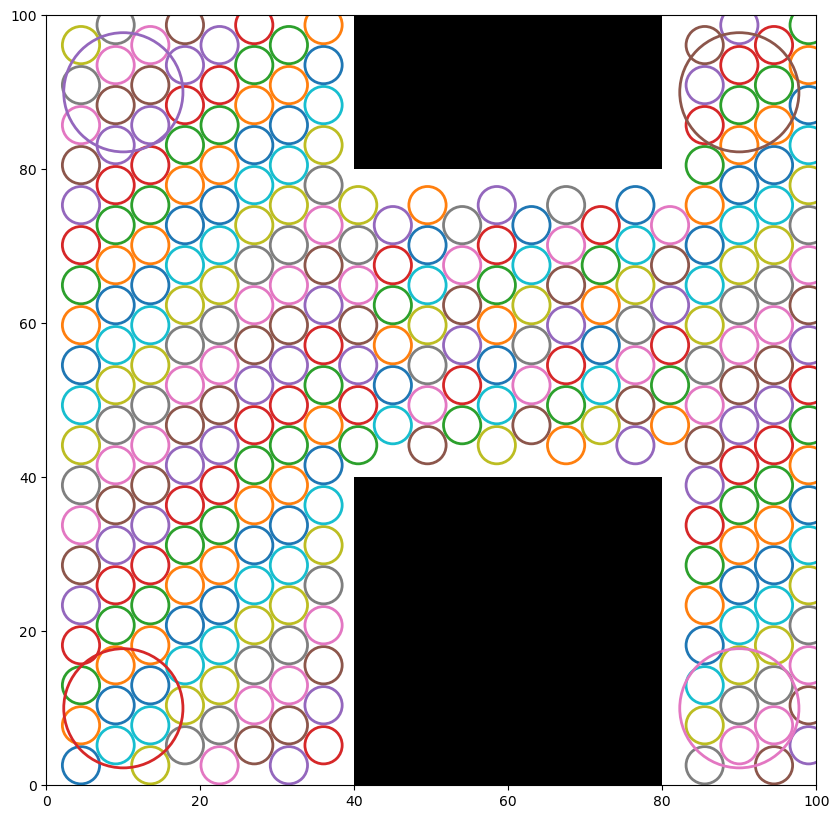

NameError: name 'simple_paths' is not defined

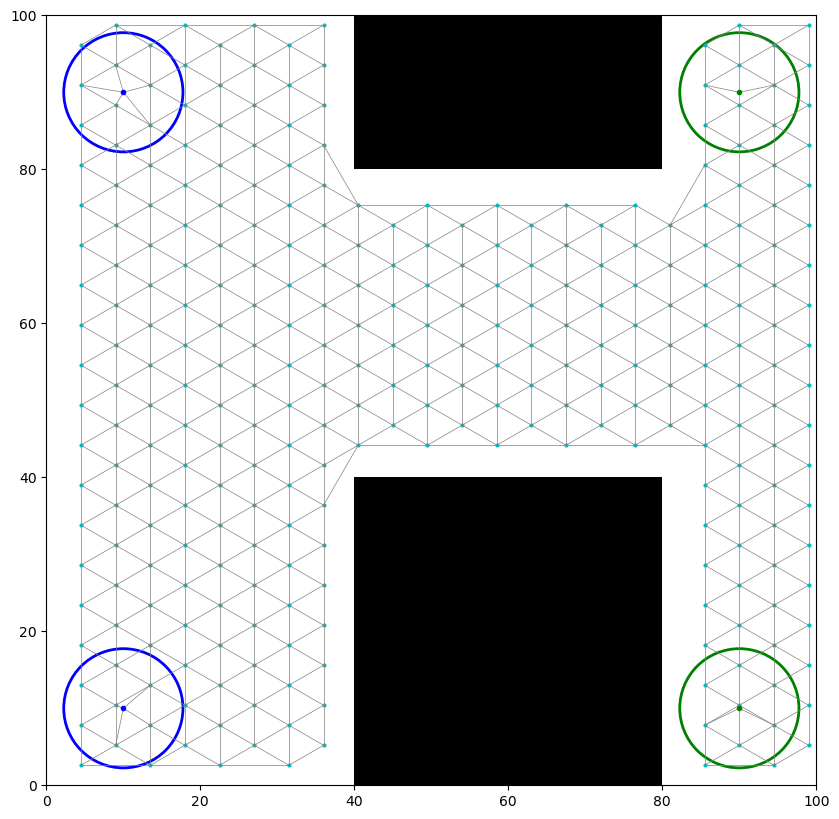

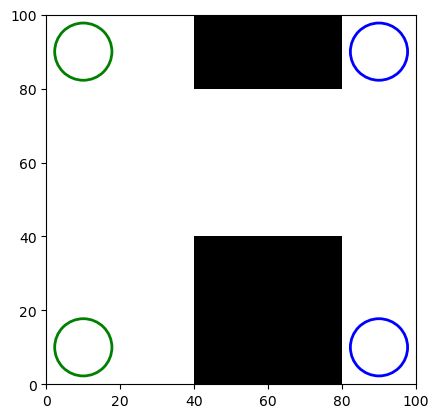

In [6]:
gaussian_prm.visualize_g_nodes()
gaussian_prm.visualize_roadmap()
fig, ax = instance.visualize()

# apf_solver.animate_solution(fig, ax)
for path in simple_paths:
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '-*', label='Path', color='blue')
# 

In [ ]:
# Verify if the macro solution is valid

for t in range(1, len(macro_sol)+1):
    moving_agents = 0
    for prev_node in  macro_sol[t].keys():
        for flow in macro_sol[t][prev_node]:
            moving_agents += flow[1]
    print(moving_agents)
    

## Gaussian Trajectory

time 1
moving agents 50
time 2
moving agents 50
[14, 22]
time 3
moving agents 50
[21, 4]
time 4
moving agents 50
[11, 0, 16, 10]
[0, 10]
time 5
moving agents 50
[1, 9, 3]
[9]
time 6
moving agents 50
time 7
moving agents 50
time 8
moving agents 50
time 9
moving agents 50
time 10
moving agents 50
time 11
moving agents 50
time 12
moving agents 50
time 13
moving agents 50
time 14
moving agents 50
time 15
moving agents 50
time 16
moving agents 50
time 17
moving agents 50
time 18
moving agents 50
time 19
moving agents 50
time 20
moving agents 48
time 21
moving agents 46
time 22
moving agents 44
time 23
moving agents 40
time 24
moving agents 35
time 25
moving agents 30
time 26
moving agents 24
time 27
moving agents 18
time 28
moving agents 8
27


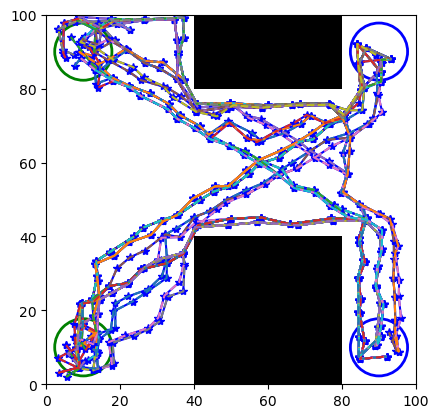

In [ ]:
import pickle
from matplotlib import pyplot as plt
from swarm_prm.solvers.micro import GaussianTrajectorySolver

with open("gaussian_prm.pkl", "rb") as f:
    gaussian_prm = pickle.load(f)

with open("macro_sol.pkl", "rb") as f:
    macro_sol = pickle.load(f)

timestep = max(macro_sol.keys())
num_agent = 50


agent_radius = 5
gt_solver = GaussianTrajectorySolver(gaussian_prm, macro_sol, timestep, num_agent)
gt_path = gt_solver.solve()

fig, ax = instance.visualize()

# apf_solver.animate_solution(fig, ax)
for path in gt_path:
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '-*', label='Path', color='blue')
# 
cmap = plt.get_cmap("tab10")

for i, path in enumerate(gt_path):
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '--', label='Path', color=cmap(i%10))

print(len(gt_path[0]))

In [ ]:
def animate_solution(fig, ax, speed):
    """
        Visualize solution trajectory provided instance
    """
    
    agents = []
    def init():
        for agent in agents:
            agent.remove()
        agents.clear()
        return []

    def update(frame):
        idx = frame * speed
        for agent in agents:
            agent.remove()
        agents.clear()
        cmap = plt.get_cmap("tab10")
        locs = [traj[idx] for traj in gt_path]
        for i, loc in enumerate(locs):
            agent = ax.add_patch(Circle(loc, radius=1, color=cmap(i%10)))
            agents.append(agent)
        return agents

    anim = FuncAnimation(fig, update, frames=len(gt_path[0]) // speed, 
                         init_func=init, blit=True, interval=100)
    anim.save("apf_solution.gif", writer='pillow', fps=6)

fig, ax = instance.visualize()
animate_solution(fig, ax, 30)